<a href="https://colab.research.google.com/github/letsGoBharat/Speech-and-Speaker-Recognition/blob/master/HMM_Gaussian_Emissions/HMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

lab2_proto.py

In [0]:
#!pip install tools2
import numpy as np
#from tools2 import *

def concatTwoHMMs(hmm1, hmm2):
    """ Concatenates 2 HMM models

    Args:
       hmm1, hmm2: two dictionaries with the following keys:
           name: phonetic or word symbol corresponding to the model
           startprob: M+1 array with priori probability of state
           transmat: (M+1)x(M+1) transition matrix
           means: MxD array of mean vectors
           covars: MxD array of variances

    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be different for each)

    Output
       dictionary with the same keys as the input but concatenated models:
          startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances

    K is the sum of the number of emitting states from the input models
   
    Example:
       twoHMMs = concatHMMs(phoneHMMs['sil'], phoneHMMs['ow'])

    See also: the concatenating_hmms.pdf document in the lab package
    """
    hmm = dict()
    startprob1 = hmm1['startprob']
    startprob2 = hmm2['startprob']
    transmat1 = hmm1['transmat']
    transmat2 = hmm2['transmat']
    means1 = hmm1['means']
    means2 = hmm2['means']
    covars1 = hmm1['covars']
    covars2 = hmm2['covars']

    # build concatenated startprob

    startprob1ext = np.append(startprob1,  np.tile(startprob1[-1], (1, startprob2.size - 1)))
    startprob2ext = np.concatenate((np.ones(startprob1.size - 1), startprob2))

    hmm["startprob"] = np.multiply(startprob1ext, startprob2ext)

    # build transition matrix

    transmat1ext = np.append(transmat1[:-1, :],  np.tile(transmat1[:-1, [-1]], (1, startprob2.size - 1)), 1)

    startrep2 = np.tile(startprob2, (startprob1.size - 1, 1))
    startrep2ext = np.concatenate((np.ones((startprob1.size - 1, startprob1.size - 1)), startrep2), axis = 1)

    firsthalf = np.multiply(transmat1ext, startrep2ext)
    secondhalf = np.concatenate((np.zeros((startprob2.size, startprob1.size - 1)), transmat2), axis = 1)

    hmm["transmat"] = np.concatenate((firsthalf, secondhalf))

    # build means matrix

    hmm["means"] = np.concatenate((means1, means2))

    # build covariances matrix

    hmm["covars"] = np.concatenate((covars1, covars2))

    return hmm
    

# this is already implemented, but based on concat2HMMs() above
def concatHMMs(hmmmodels, namelist):
    """ Concatenates HMM models in a left to right manner

    Args:
       hmmmodels: dictionary of models indexed by model name. 
       hmmmodels[name] is a dictionaries with the following keys:
           name: phonetic or word symbol corresponding to the model
           startprob: M+1 array with priori probability of state
           transmat: (M+1)x(M+1) transition matrix
           means: MxD array of mean vectors
           covars: MxD array of variances
       namelist: list of model names that we want to concatenate

    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be
      different in each model)

    Output
       combinedhmm: dictionary with the same keys as the input but
                    combined models:
         startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances

    K is the sum of the number of emitting states from the input models

    Example:
       wordHMMs['o'] = concatHMMs(phoneHMMs, ['sil', 'ow', 'sil'])
    """
    concat = hmmmodels[namelist[0]]
    for idx in range(1,len(namelist)):
        concat = concatTwoHMMs(concat, hmmmodels[namelist[idx]])
    return concat


def gmmloglik(log_emlik, weights):
    """Log Likelihood for a GMM model based on Multivariate Normal Distribution.

    Args:
        log_emlik: array like, shape (N, K).
            contains the log likelihoods for each of N observations and
            each of K distributions
        weights:   weight vector for the K components in the mixture

    Output:
        gmmloglik: scalar, log likelihood of data given the GMM model.
    """
    gmmloglik = 0
    arrayloglik = np.empty(gmm_emlik.shape)
    for i in range(gmm_emlik.shape[0]):
      loglik = gmm_emlik[i]
      log_weights = np.log(W)
      logsum = loglik + log_weights
      arrayloglik[i] = logsum
      print(logsum)
      gmmloglik = gmmloglik + logsumexp(logsum)
    print(gmmloglik)
    
    return arrayloglik

    

def forward(log_emlik, log_startprob, log_transmat):
    """Forward (alpha) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: log transition probability from state i to j

    Output:
        forward_prob: NxM array of forward log probabilities for each of the M states in the model
    """
    alpha = np.empty((log_emlik.shape[0], log_emlik.shape[1]))
    alpha[0] = log_startprob[0:-1] + log_emlik[0, :]
    for i in range (1, alpha.shape[0]):
      for j in range (0, alpha.shape[1]):
        alpha[i][j] = logsumexp(alpha[i - 1] + log_transmat[:-1, j]) + log_emlik[i, j]

    return alpha

def backward(log_emlik, log_startprob, log_transmat):
    """Backward (beta) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j

    Output:
        backward_prob: NxM array of backward log probabilities for each of the M states in the model
    """

    bet = np.empty((log_emlik.shape[0], log_emlik.shape[1]))
    bet[log_emlik.shape[0] - 1] = np.zeros(log_emlik.shape[1])
    for i in range (log_emlik.shape[0] - 2,  -1, -1):
      for j in range (0, bet.shape[1]):
        bet[i][j] = logsumexp(log_transmat[j, :-1] + log_emlik[i + 1] + bet[i + 1])
    return bet


def backtrack_viterbi(B, last_idx):
    best_path = [last_idx]
    for i in range(B.shape[0]-1, 0, -1):
      best_path.append(int(B[i, best_path[-1]]))

    best_path.reverse()
    return best_path


def viterbi(log_emlik, log_startprob, log_transmat, forceFinalState=True):
    """Viterbi path.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j
        forceFinalState: if True, start backtracking from the final state in
                  the model, instead of the best state at the last time step

    Output:
        viterbi_loglik: log likelihood of the best path
        viterbi_path: best path
    """
    emissions = log_emlik.shape[0]
    states = log_emlik.shape[1]
    B = np.zeros((emissions, states))
    V = np.zeros((emissions, states))
    V[0] = log_startprob[0:-1] + log_emlik[0, :]
    for i in range(1, emissions):
      for j in range(states):
        V[i][j] = np.max(V[i - 1, :] + log_transmat[:-1, j]) + log_emlik[i, j]
        B[i][j] = np.argmax(V[i - 1, :] + log_transmat[:-1, j])
      
    max_last_index = np.argmax(V[emissions-1])
    viterbi_path = backtrack_viterbi(B, max_last_index);
    viterbi_loglik = np.max(V[emissions-1]) #to check at time t(last emission)
    return viterbi_loglik, viterbi_path

def statePosteriors(log_alpha, log_beta):
    """State posterior (gamma) probabilities in log domain.

    Args:
        log_alpha: NxM array of log forward (alpha) probabilities
        log_beta: NxM array of log backward (beta) probabilities
    where N is the number of frames, and M the number of states

    Output:
        log_gamma: NxM array of gamma probabilities for each of the M states in the model
    """

    log_gamma = np.empty((log_alpha.shape[0], log_alpha.shape[1]))

    log_gamma = log_alpha + log_beta - logsumexp(log_alpha[-1])

    return log_gamma

def updateMeanAndVar(X, log_gamma, varianceFloor=5.0):
    """ Update Gaussian parameters with diagonal covariance

    Args:
         X: NxD array of feature vectors
         log_gamma: NxM state posterior probabilities in log domain
         varianceFloor: minimum allowed variance scalar
    were N is the lenght of the observation sequence, D is the
    dimensionality of the feature vectors and M is the number of
    states in the model

    Outputs:
         means: MxD mean vectors for each state
         covars: MxD covariance (variance) vectors for each state
    """
    means = np.empty((log_gamma.shape[1], X.shape[1]))
    covars = np.empty(means.shape)
    gamma = np.exp(log_gamma)

    gamma_sum = np.sum(gamma, axis=0)

    for i in range(means.shape[0]):
        means[i] = np.sum(gamma[: , [i]] * X, axis = 0) / gamma_sum[i]
        covars[i] = np.sum(gamma[: , [i]] * (X - means[i])**2, axis = 0) / gamma_sum[i]
        covars[i, covars[i] < varianceFloor] = varianceFloor
    return (means, covars)

def train(data, model, it = 20, threshold = 1):
    prevloglik = - math.inf
    for i in range(it) :
      obsloglik = log_multivariate_normal_density_diag(data, model['means'], model['covars'])

      alpha = forward(obsloglik , np.log(model['startprob']), np.log(model['transmat']))
      loglik = logsumexp(alpha[-1])

      print(loglik)

      if((np.abs(loglik - prevloglik) < threshold) and prevloglik != - math.inf):
            break

      prevloglik = loglik
      beta = backward(obsloglik, np.log(model['startprob']), np.log(model['transmat']))
      log_gamma = statePosteriors(alpha, beta)

      model['means'], model['covars'] = updateMeanAndVar(data, log_gamma)

    print("Final loglik: " + str(prevloglik))
    return model



lab2_tools.py

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time

def logsumexp(arr, axis=0):
    """Computes the sum of arr assuming arr is in the log domain.
    Returns log(sum(exp(arr))) while minimizing the possibility of
    over/underflow.
    """
    arr = np.rollaxis(arr, axis)
    # Use the max to normalize, as with the log this is what accumulates
    # the less errors
    vmax = arr.max(axis=0)
    if vmax.ndim > 0:
        vmax[~np.isfinite(vmax)] = 0
    elif not np.isfinite(vmax):
        vmax = 0
    with np.errstate(divide="ignore"):
        out = np.log(np.sum(np.exp(arr - vmax), axis=0))
        out += vmax
        return out

def log_multivariate_normal_density_diag(X, means, covars):
    """Compute Gaussian log-density at X for a diagonal model

    Args:
        X: array like, shape (n_observations, n_features)
        means: array like, shape (n_components, n_features)
        covars: array like, shape (n_components, n_features)

    Output:
        lpr: array like, shape (n_observations, n_components)
    From scikit-learn/sklearn/mixture/gmm.py
    """
    n_samples, n_dim = X.shape
    lpr = -0.5 * (n_dim * np.log(2 * np.pi) + np.sum(np.log(covars), 1)
                  + np.sum((means ** 2) / covars, 1)
                  - 2 * np.dot(X, (means / covars).T)
                  + np.dot(X ** 2, (1.0 / covars).T))
    return lpr

def plot_colormesh(input):
    plt.pcolormesh(input.T)
    plt.show()

def plot_overlay(input1, input2):
    plt.pcolormesh(input1.T)
    plt.plot(input2, color = 'red')
    plt.show()

def alpha_viterbi_performance(data, is_alpha = True, is_viterbi = True):
  #Alpha - 
  #Recognizes women utterances correctly but men utterances not very well for single speaker model
  #Recognizes all women and men utterances correctly except for digit 9 spoken by a woman for all speaker model
  #Viterbi - 
  #Recognizes women utterances correctly but men utterances not very well for single speaker model
  #Recognizes all women and men utterances correctly for all speaker model
    if(is_alpha and is_viterbi):
      print("Alpha and Viterbi Performance")
    elif(is_viterbi):
      print("Viterbi Performance")
    else:
      print("Alpha Performance")
    print("Performance on models trained on a single speaker")
    count_v = 0
    count_a = 0
    counter_all = 0
    key_size = len(prondict.keys())
    time_vit = np.zeros(key_size)
    end_time_vit = np.zeros(key_size)
    time_al = np.zeros(key_size)
    end_time_al = np.zeros(key_size)
    time_vit_all = np.zeros(key_size)
    end_time_vit_all = np.zeros(key_size)
    time_al_all = np.zeros(key_size)
    end_time_al_all = np.zeros(key_size)
    for d in data:
      #print("Digit " + d['digit'] + " by " + d['gender'])
      max_v = -math.inf
      max_a = -math.inf
      dig_v = "-1"
      dig_a = "-1"
      for i, digit in enumerate(prondict.keys()):
        if is_viterbi == True:
          time_vit[i] = time.time()
          loglik_v, _ = viterbi(log_multivariate_normal_density_diag(d['lmfcc'], wordHMMs_ones[digit]['means'], wordHMMs_ones[digit]['covars']), np.log(wordHMMs_ones[digit]['startprob']), np.log(wordHMMs_ones[digit]['transmat']), True)
          end_time_vit[i] = time.time()
          if max_v < loglik_v:
            max_v  = loglik_v
            dig_v = digit       
        if is_alpha == True:
          time_al[i] = time.time()
          alpha = forward(log_multivariate_normal_density_diag(d['lmfcc'], wordHMMs_ones[digit]['means'], wordHMMs_ones[digit]['covars']), np.log(wordHMMs_ones[digit]['startprob']), np.log(wordHMMs_ones[digit]['transmat']))
          end_time_al[i] = time.time()
          loglik_a = logsumexp(alpha[-1])
          if max_a < loglik_a:
            max_a  = loglik_a
            dig_a = digit 
      #if(is_viterbi):
        #print("Max likelihood digit viterbi: " + dig_v)
      #if(is_alpha):
        #print("Max likelihood digit alpha: " + dig_a)
      if(dig_v == d['digit']):
        count_v += 1
      if(dig_a == d['digit']):
        count_a += 1
      counter_all += 1
    if(is_viterbi):
      print("Viterbi performance: " + str(round((count_v / counter_all)*100)) + "%" )
      print("Viterbi time : " + str(np.average(end_time_vit - time_vit)))
    if(is_alpha):
      print("Alpha performance: " + str(round((count_a / counter_all)*100)) + "%" )
      print("Alpha time : " + str(np.average(end_time_al - time_al)))

    print("Performance on models trained on all speakers")
    count_v = 0
    count_a = 0
    counter_all = 0
    for d in data:
      #print("Digit " + d['digit'] + " by " + d['gender'])
      max_v = -math.inf
      max_a = -math.inf
      dig_v = "-1"
      dig_a = "-1"
      for j, digit in enumerate(prondict.keys()):
        if is_viterbi == True:
          time_vit_all[j] = time.time()
          loglik_v, _ = viterbi(log_multivariate_normal_density_diag(d['lmfcc'], wordHMMs_all[digit]['means'], wordHMMs_all[digit]['covars']), np.log(wordHMMs_all[digit]['startprob']), np.log(wordHMMs_all[digit]['transmat']), True)
          end_time_vit_all[j] = time.time()
          if max_v < loglik_v:
            max_v  = loglik_v
            dig_v = digit       
        if is_alpha == True:
          time_al_all[j] = time.time()
          alpha = forward(log_multivariate_normal_density_diag(d['lmfcc'], wordHMMs_all[digit]['means'], wordHMMs_all[digit]['covars']), np.log(wordHMMs_all[digit]['startprob']), np.log(wordHMMs_all[digit]['transmat']))
          end_time_al_all[j] = time.time()
          loglik_a = logsumexp(alpha[-1])
          if max_a < loglik_a:
            max_a  = loglik_a
            dig_a = digit 
      #if(is_viterbi):
        #print("Max likelihood digit viterbi: " + dig_v)
      #if(is_alpha):
        #print("Max likelihood digit alpha: " + dig_a)
      if(dig_v == d['digit']):
        count_v += 1
      if(dig_a == d['digit']):
        count_a += 1
      counter_all += 1
    if(is_viterbi):
      print("Viterbi performance: " + str(round((count_v / counter_all)*100)) + "%" )
      print("Viterbi time : " + str(np.average(end_time_vit_all - time_vit_all)))
    if(is_alpha):
      print("Alpha performance: " + str(round((count_a / counter_all)*100)) + "%" )
      print("Alpha time : " + str(np.average(end_time_al_all - time_al_all)))



prondict.py

In [0]:
prondict = {} 
prondict['o'] = ['ow']
prondict['z'] = ['z', 'iy', 'r', 'ow']
prondict['1'] = ['w', 'ah', 'n']
prondict['2'] = ['t', 'uw']
prondict['3'] = ['th', 'r', 'iy']
prondict['4'] = ['f', 'ao', 'r']
prondict['5'] = ['f', 'ay', 'v']
prondict['6'] = ['s', 'ih', 'k', 's']
prondict['7'] = ['s', 'eh', 'v', 'ah', 'n']
prondict['8'] = ['ey', 't']
prondict['9'] = ['n', 'ay', 'n']


main.py

HMM concatenation correct? True
'o' repetition a


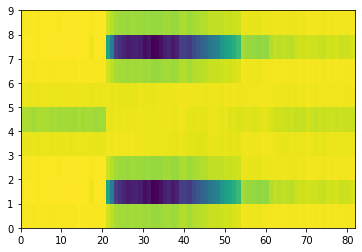

'o' repetition b


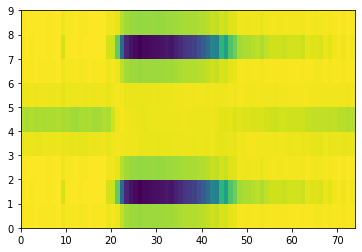

'z' repetition a


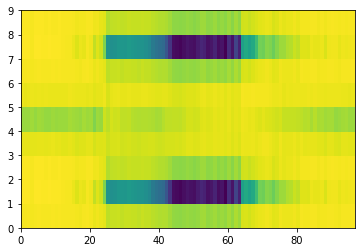

Forward algorithm correct? True


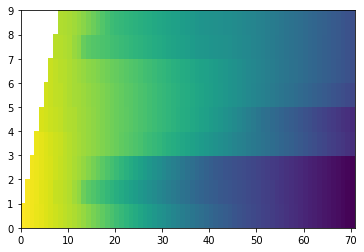

Alpha loglik calculation correct? True
Viterbi algorithm correct? True
Best path over the alpha array


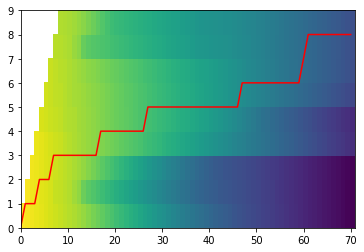

Alpha and Viterbi Performance
Performance on models trained on a single speaker
Viterbi performance: 77%
Viterbi time : 0.012678926641290838
Alpha performance: 77%
Alpha time : 0.030445900830355557
Performance on models trained on all speakers
Viterbi performance: 100%
Viterbi time : 0.013023311441594904
Alpha performance: 98%
Alpha time : 0.0298446308482777
Backward algorithm correct? True


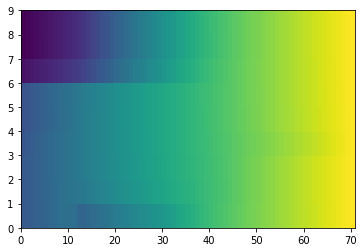

Beta loglik calculation correct? True
State Posteriors algorithm correct? True


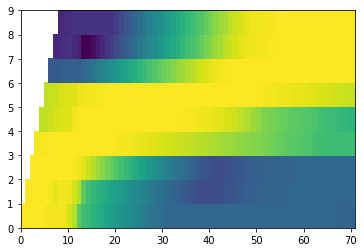

Best path over the gamma array


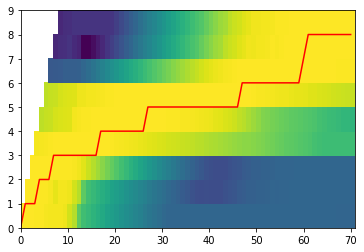

Shows most probable states across the sequence
[ 1.34597458  2.09555994  3.55849998  9.73752276 10.12040999 20.5329264
 12.9968938   1.20869929  9.40351326]
Shows number of timesteps
70.99999999991067
o
-7070.173641433824
-6451.298123187103
-6352.529477038971
-6321.501698999804
-6318.817002586533
-6318.813712693776
Final loglik: -6318.817002586533
z
-7143.504083282199
-6017.283352786079
-5859.881315186365
-5837.618329981167
-5833.270132558103
-5833.269941122307
Final loglik: -5833.270132558103
1
-7041.542140050837
-6190.523823350007
-5996.860424783219
-5955.94369676865
-5928.814863143339
-5919.2712835662
-5914.647750120028
-5911.803921583946
-5905.810988421305
-5903.338236248108
-5903.338236248112
Final loglik: -5903.338236248108
2
-7184.0166018939335
-6400.201464305467
-6237.948407220546
-6210.977355961968
-6190.887383004326
-6190.69626333299
Final loglik: -6190.887383004326
3
-7096.438548997854
-6193.800098131099
-6054.794195727289
-6012.101133772825
-6012.100485930711
Final loglik: 

In [4]:
#ignore runtime warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
import math
from sklearn.mixture import GaussianMixture as GMM

data = np.load('lab2_data.npz', allow_pickle=True)['data']
 
phoneHMMs_all = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
phoneHMMs_ones = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()

isolated = {}
wordHMMs_ones = {}
wordHMMs_all = {}
for digit in prondict.keys():
  isolated[digit] = ['sil'] + prondict[digit] + ['sil']
  wordHMMs_ones[digit] = concatHMMs(phoneHMMs_ones, isolated[digit])
  wordHMMs_all[digit] = concatHMMs(phoneHMMs_all, isolated[digit])
  

# Verify hmm concatenation correctness
print("HMM concatenation correct? " + str(np.allclose(log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs_ones['o']['means'], wordHMMs_ones['o']['covars']), example['obsloglik'])))

print("\'o\' repetition a")
plot_colormesh(log_multivariate_normal_density_diag(data[0]['lmfcc'], wordHMMs_ones['o']['means'], wordHMMs_ones['o']['covars']))
print("\'o\' repetition b")
plot_colormesh(log_multivariate_normal_density_diag(data[1]['lmfcc'], wordHMMs_ones['o']['means'], wordHMMs_ones['o']['covars']))
print("\'z\' repetition a")
plot_colormesh(log_multivariate_normal_density_diag(data[2]['lmfcc'], wordHMMs_ones['o']['means'], wordHMMs_ones['o']['covars']))


# Verify forward function correctness
alpha = forward(example['obsloglik'], np.log(wordHMMs_ones['o']['startprob']), np.log(wordHMMs_ones['o']['transmat']))
print("Forward algorithm correct? " + str(np.allclose(alpha, example['logalpha'])))
plot_colormesh(alpha)
print("Alpha loglik calculation correct? " + str(np.allclose(logsumexp(alpha[-1]), example['loglik']))) # not sure of this is what the question meant!


# Verify viterbi function correctness
viterbi_loglik, viterbi_path = viterbi(example['obsloglik'], np.log(wordHMMs_ones['o']['startprob']), np.log(wordHMMs_ones['o']['transmat']), True)
print("Viterbi algorithm correct? " + str(np.allclose(viterbi_loglik, example['vloglik'])))

#print('Best Path :' + str(viterbi_path))

print("Best path over the alpha array")
plot_overlay(alpha, viterbi_path)

#Alpha Viterbi Performance
check_alpha = True
check_viterbi = True
alpha_viterbi_performance(data, check_alpha, check_viterbi)

# Verify backward function correctness
beta = backward(example['obsloglik'], np.log(wordHMMs_ones['o']['startprob']), np.log(wordHMMs_ones['o']['transmat']))
print("Backward algorithm correct? " + str(np.allclose(beta, example['logbeta'])))
plot_colormesh(beta)
print("Beta loglik calculation correct? " + str(np.allclose(logsumexp(np.log(wordHMMs_ones['o']['startprob'][:-1]) + example['obsloglik'][0, :] + beta[0]), example['loglik'])))

# Verify posteriors function correctness
log_gamma = statePosteriors(alpha, beta)
print("State Posteriors algorithm correct? " + str(np.allclose(np.sum(np.exp(log_gamma), 1), np.ones((1, log_gamma.shape[0])))))
plot_colormesh(log_gamma)

print("Best path over the gamma array")
plot_overlay(log_gamma, viterbi_path)

# shows most probable states across the sequence
print("Shows most probable states across the sequence")
print(np.sum(np.exp(log_gamma), 0))
# number of timesteps
print("Shows number of timesteps")
print(np.sum(np.exp(log_gamma)))


for digit in prondict.keys():
  print(digit)
  model = train(data[10]['lmfcc'], wordHMMs_all[digit])


[ -88.55847196  -84.3353631   -82.76875475 -101.75035069 -207.71846173
 -102.91805275  -88.55847196  -84.3353631   -82.76875475]
[ -81.99970503  -81.77519245  -79.0067477   -95.49601916 -209.72975756
 -100.31423149  -81.99970503  -81.77519245  -79.0067477 ]
[ -86.91087213  -82.71998068  -81.85199904 -102.38315217 -201.73950847
  -95.82826715  -86.91087213  -82.71998068  -81.85199904]
[ -81.7481462   -75.39956614  -76.59927333  -95.2241436  -202.02896212
  -96.70543658  -81.7481462   -75.39956614  -76.59927333]
[ -89.83430107 -106.63253911  -86.40748912  -93.07311697 -206.54100144
 -104.00083579  -89.83430107 -106.63253911  -86.40748912]
[ -90.39452138  -86.4917435   -86.05399733 -100.43253984 -208.77324522
  -99.31667883  -90.39452138  -86.4917435   -86.05399733]
[ -85.61023632  -93.11006682  -81.76540059  -94.43521531 -199.82780275
 -101.3298932   -85.61023632  -93.11006682  -81.76540059]
[-105.04094525 -176.37408864 -106.896394    -93.94660028 -174.87081149
 -112.51536796 -105.040945

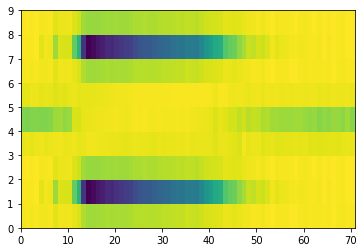

In [7]:
#GMM Posteriors
K = example['obsloglik'].shape[1]
W = [1/K] * K
W = np.array(W)
gmm_emlik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs_ones['o']['means'], wordHMMs_ones['o']['covars'])

gmm_log_lik = gmmloglik(gmm_emlik, W)
plot_colormesh(gmm_log_lik)